## Importation des Bibliothèques

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Récupération et Normalisation des données

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "data", label_mode=None, image_size=(96, 96), batch_size=16
)
dataset = dataset.map(lambda x: x / 255.0)


Found 80 files belonging to 1 classes.


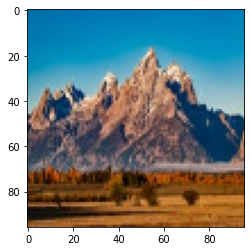

In [3]:
for i in dataset:
    for j in i:
        plt.imshow(j)
        break

## Création du discriminateur

Les images en entrée seront de 256 * 256 et la sortie sera un résultat binaire

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(96, 96, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)           

## Création du generateur

In [5]:
latent_dim = 128

if os.path.exists("last_model.h5"):
    print("Recuperation")
    generator = keras.models.load_model("last_model.h5")
else:
    print("Modelisation")
    generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(12 * 12 * 128),
            #layers.LeakyReLU(alpha=0.2),
            layers.Reshape((12, 12, 128)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )
generator.summary()

Modelisation
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18432)             2377728   
_________________________________________________________________
reshape (Reshape)            (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 48, 48, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 96, 96, 

## Réécritue de `train_step`

In [6]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
## Train the end-to-end model

## Callback

In [7]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.count      = 0

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_images/generated_img_%03d_%d.png" % (epoch, i))
    
    def on_epoch_begin(self, epoch, logs=None):
        self.model.generator.save("models/model_{}.h5".format(str(self.count)))
        self.model.discriminator.save("discriminators/discrim_{}.h5".format(str(self.count)))
        self.count += 1

## Train the end-to-end model

In [8]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
history = gan.fit(
    dataset, epochs=epochs, callbacks = GANMonitor()
)

Epoch 1/10
5/5 [==============================] - 26s 5s/step - d_loss: 0.6366 - g_loss: 0.6836
Epoch 2/10
5/5 [==============================] - 28s 6s/step - d_loss: 0.5452 - g_loss: 0.5867
Epoch 3/10
5/5 [==============================] - 26s 5s/step - d_loss: 0.7029 - g_loss: 0.3770
Epoch 4/10
5/5 [==============================] - 27s 5s/step - d_loss: 0.8537 - g_loss: 0.3362
Epoch 5/10
5/5 [==============================] - 29s 6s/step - d_loss: 0.7282 - g_loss: 0.6260
Epoch 6/10


In [ ]:
random_latent_vectors = tf.random.normal(shape=(5, 128))
result = generator.predict(random_latent_vectors)

In [ ]:
for image in result:
    plt.imshow(image.astype('uint8'))
    plt.show()

###### 

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['d_loss'])
plt.show()

In [ ]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.show()